In [1]:
import numpy as np
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from numpy import absolute
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [2]:
#import data
df = pd.read_csv('../input/instagram-reach/instagram_reach.csv')

In [3]:
#head of data
df.head()

,Unnamed: 0,S.No,USERNAME,Caption,Followers,Hashtags,Time since posted,Likes
0,0,1,mikequindazzi,Who are #DataScientist and what do they do? >>...,1600,#MachineLearning #AI #DataAnalytics #DataScien...,11 hours,139
1,1,2,drgorillapaints,We all know where it’s going. We just have to ...,880,#deck .#mac #macintosh#sayhello #apple #steve...,2 hours,23
2,2,3,aitrading_official,Alexander Barinov: 4 years as CFO in multinati...,255,#whoiswho #aitrading #ai #aitradingteam#instat...,2 hours,25
3,3,4,opensourcedworkplace,sfad,340,#iot #cre#workplace #CDO #bigdata #technology#...,3 hours,49
4,4,5,crea.vision,Ever missed a call while your phone was chargi...,304,#instamachinelearning #instabigdata#instamarke...,3 hours,30


In [4]:
#check info of data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         100 non-null    int64 
 1   S.No               100 non-null    int64 
 2   USERNAME           100 non-null    object
 3   Caption            94 non-null     object
 4   Followers          100 non-null    int64 
 5   Hashtags           100 non-null    object
 6   Time since posted  100 non-null    object
 7   Likes              100 non-null    int64 
dtypes: int64(4), object(4)
memory usage: 6.4+ KB
None


There are missing values on Caption column

## Data Cleaning

### Remove unnecessary column

In [5]:
#because there is only 6 main features (columns), "Unnamed:0" and "S.No" columns will removed
df2 = df.copy()
df2.drop(['Unnamed: 0','S.No'], inplace=True,axis=1)

### Dealing with missing values

In [6]:
#only Caption column that has missing values so missing values will be dropped
df2=df2.dropna()

### Change data type

In [7]:
#Times since posted will be better if in type of int/float, so it will be changed
Time_since_posted_in_hours=[]

for i in df2['Time since posted']:
    Time_since_posted_in_hours.append(i.replace('hours', ''))

df2.rename(columns={'USERNAME':'Username'}, inplace=True)
se = pd.Series(Time_since_posted_in_hours)
df2['Times since posted (hours)'] = se.values
df2['Times since posted (hours)'] = pd.to_numeric(df2['Times since posted (hours)'])
df2 = df2.drop('Time since posted', axis=1)

In [8]:
#check new data
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Username                    94 non-null     object
 1   Caption                     94 non-null     object
 2   Followers                   94 non-null     int64 
 3   Hashtags                    94 non-null     object
 4   Likes                       94 non-null     int64 
 5   Times since posted (hours)  94 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 5.1+ KB


## Exploratory Data Analysis

1. Followers variable

Let's look at the distribution

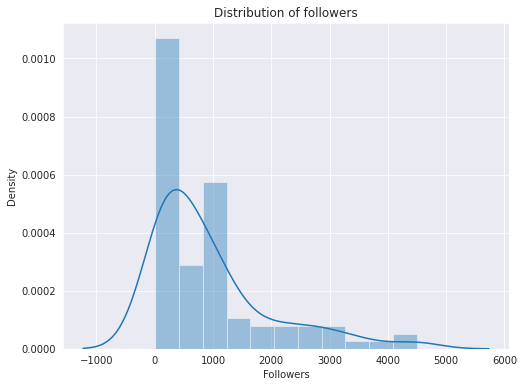

In [9]:
#Distribution of followers variable
plt.figure(figsize=(8, 6))
sns.distplot(df2['Followers'])
plt.title("Distribution of followers")
plt.show()

The followers distribution in right skewed. Most of the account has followers between 0-300 or more

2. Time_since_posted_in_hours variable

Let's look at the distribution

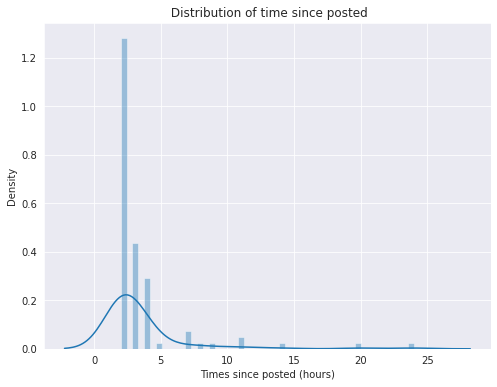

In [10]:
plt.figure(figsize=(8,6))
sns.distplot(df2['Times since posted (hours)'])
plt.title(' Distribution of time since posted')
plt.show()

The Time_since_posted_hours distribution is right skewed

3. Username variable

Unique usename

In [11]:
print('There are', df2['Username'].nunique(), 'username')

There are 90 username


Out of 94 data, there are 90 unique users. That's quite a lot

4. Caption variables

In analyzing this variable, I will use wordcloud to know which words are mostly used in caption

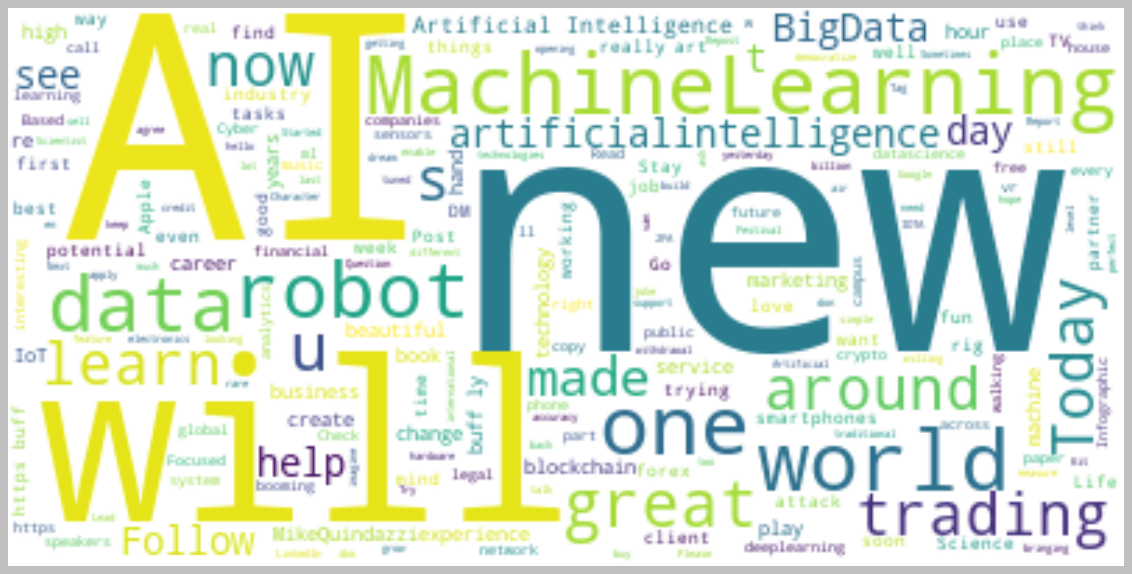

In [12]:
text = " ".join(i for i in df2.Caption)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.style.use('classic')
plt.figure( figsize=(18,16))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

From wordcloud above we know that words like 'AI', 'will', 'new' are the top three words on caption

5. Hastags variable

In analyzing this variable, I will use wordcloud to know which words are mostly used in hastags

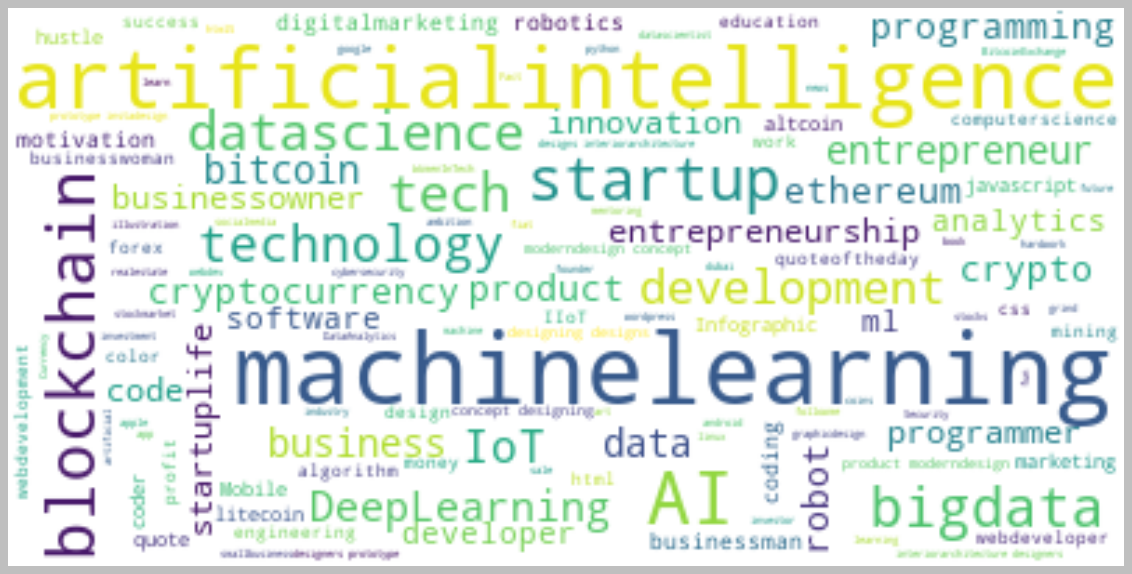

In [13]:
text = " ".join(i for i in df2.Hashtags)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.style.use('classic')
plt.figure( figsize=(18,16))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

From wordcloud above we know that words like 'artificialintelligence', 'machinelearning', 'AI' are the top three words on hashtags

### Relationship between two variables

1. Times since posted in hours and likes

I will use scatterplot to visualize the relationship between these variables

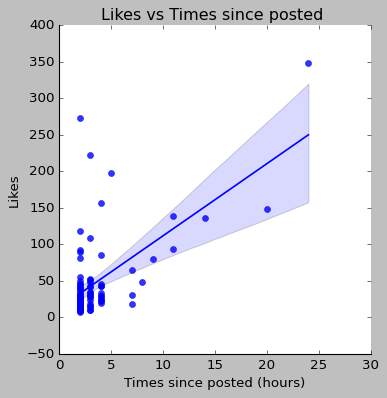

In [14]:
sns.lmplot(x='Times since posted (hours)', y='Likes', data=df2, fit_reg=True, scatter_kws={"marker": "D", "s": 30})

plt.title('Likes vs Times since posted ')
plt.xlabel('Times since posted (hours)')
plt.ylabel('Likes')
plt.show()

There is linear relationship between times since posted and likes. Some data shows no relationship between these two

2. Followers and likes

I will use scatterplot to visualize the relationship between these variables

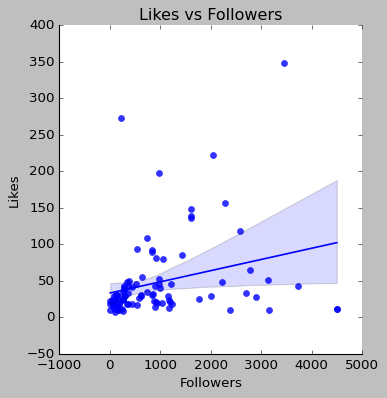

In [15]:
sns.lmplot(x='Followers', y='Likes', data=df2, fit_reg=True, scatter_kws={"marker": "D", "s": 30})

plt.title('Likes vs Followers')
plt.xlabel('Followers')
plt.ylabel('Likes')
plt.show()

There is linear relationship between these two variables

Now I will find out the correlation values between times since posted, follower, and likes

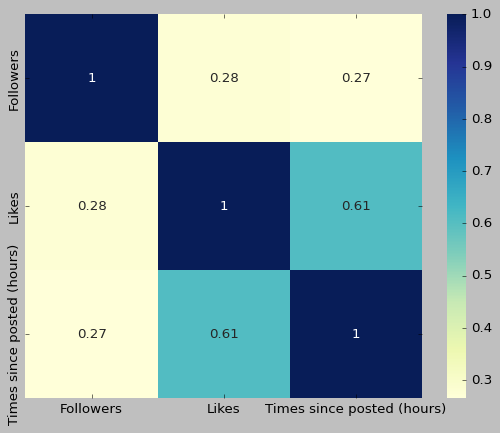

In [16]:
plt.figure(figsize=(8, 6))
sns.heatmap(df2.corr(), cmap="YlGnBu", annot=True)
plt.show()

There is strong correlation between likes and times since posted in hours

## Modelling

Predicting reach with XGBRegressor

In [17]:
#Define x variables and y variable
x = df2[['Followers', 'Times since posted (hours)']]
y = df2['Likes']
df.head()

#Split train set and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [18]:
#Fit the model and predict the value of test set
model = XGBRegressor()
model.fit(X_train, y_train)

#Define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
#Evaluate the model
scores = cross_val_score(model, X_test, y_test, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#Absolute MAE
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()))

Mean MAE: 18.272 (8.974)


The XGBoost model achieved a mean MAE of 18.272 and MAE std of 8.974

Using linear regression

In [19]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

#Define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
#Evaluate the model
scores = cross_val_score(lin_reg, X_test, y_test, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#Absolute MAE
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 17.737 (11.099)


The Linear Regression model achieved a mean MAE of 17.737 and MAE std of 11.099

In [20]:
#check coefficient of determination of linear regression model
r_sq = lin_reg.score(x, y)
print(f"coefficient of determination: {r_sq}")

coefficient of determination: 0.3814063866179843


Linear Regression model is not better than XGBoost

In [21]:
#Predict new value using XGBoost
X_new = np.array([[240, 7]])
model.predict(X_new)

array([0.13489202], dtype=float32)

Summary

This is how you can analyze and predict the likes of Instagram posts with machine learning using Python. With this notebook, we could know the example of Data Science role in social media. I hope you could give feedback and advice to this notebook. Thank you.

References : 

https://thecleverprogrammer.com/2022/03/22/instagram-reach-analysis-using-python/
https://machinelearningmastery.com/xgboost-for-regression/